# Code for Movielens experiments from "Fairness in Ranking under Uncertainty" paper submission.

This notebook contains the relevant code to reproduce the results of the paper. 


In [1]:
import warnings
warnings.filterwarnings('ignore')
# this helps remove warnings which may deanonymize authors through pathnames.

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsfonts}"

In [3]:
import tqdm
from pprint import pprint
from scipy.optimize import linprog
import seaborn as sns

In [4]:
from preprocess_movielens_dataset import *
from linear_program import get_linprog_coeffs_movielens
from evaluation import *
from sample_rankings_util import *
from plot_utils import plot_all, plot_distributions, plot_stacked_distributions

## Library Structure

The library is arranged as follows:
- preprocess_movielens_dataset.py: Provides functionality to load and preprocess the movielens dataset as described in the paper.
- linear_program.py: Provides necessary functions to transform the ranking problem to the linear program that can be solved by an off-the-shelf LP solver.
- sample_rankings.py: Provides utility functions to work with ranking distributions. 
- plot_utils.py: Utility functions to plot the graphs and visualizations shown below.

The function below runs a single experiment for a particular sampling of the dataset, and comparing the Linear Program ranking policies ($\pi^{{\rm LP}, \phi}$) with OPT/TS mixing policies ($\pi^{{\rm Mix}, \phi}$) for different values of $\phi$.

## Movielens Experiment Setup

The MovieLens-100k dataset contains 100,000 ratings, by 600 users, on 9,000 movies belonging to 18 genres (Harper et al. 2015).
In our setup, for each user, the principal is a recommender system that has to generate a ranking of movies for one of the genres $g$ (e.g., Horror, Romance, Comedy, etc.), according to a notion of *merit* of the movies we define as follows.


Download the ML-100K dataset from https://grouplens.org/datasets/movielens/latest/
Unzip the ml-latest-small.zip file into a directory inside the current directory. 

In [5]:
datadir = './ml-latest-small/'
# make sure the directory has the following files
# - ratings.csv
# - movies.csv


We assume that each rating of a movie $m \in \mathcal{S}_g$ is drawn from a multinomial distribution over $\{1, 2, 3, 4, 5\}$ with (unknown) parameters $\mathbf{\theta}_m = (\theta_{m,1}, \ldots, \theta_{m,5})$.

- Prior: These parameters themselves follow a Dirichlet prior
$\mathbf{\theta}_m \sim \Gamma(\alpha)$
with known parameters $\mathbf{\alpha } = (\alpha_{1}, \alpha_{2}, \alpha_{3}, \alpha_{4}, \alpha_{5})$.
We assume that the parameters of the Dirichlet prior are of the form $\alpha_{r} = s \cdot p_r$ where $s$ is a scaling factor and $p_r = P(Rating=r|Dataset)$ denotes the marginal probability of observing the rating $r$ in the full MovieLens dataset. 

    The scaling factor $s$ determines the weight of the prior compared to the observed data, since it acts as a pseudo-count in $\mathbf{\alpha }'$ below. For the sake of simplicity, we use $s=1.0$ in the following for all movies and genres.

- Posterior:
Since the Dirichlet distribution is the conjugate prior of the multinomial distribution, the posterior distribution based on the ratings observed in the dataset \Dataset is also a Dirichlet distribution, but with parameters $\mathbf{\alpha}' = (\mathbf{\alpha}+N_{m}) = (\alpha{1}+N_{m,1},\: \ldots ,\: \alpha_{5}+N_{m,5})$ where $N_{m,r}$ is the number of ratings of $r$ for the movie $m$ in the dataset D. 

**Expected Merit**

The optimal ranking policy $\pi^{\rm *}$ sorts the movies (for the particular query) by decreasing expected merit, which is the expected average rating $\overline{r}_m$ under the posterior Dirichlet distribution, and can be computed in closed form as follows:

$\overline{r}_m \triangleq E[\mathbf{\theta} \sim P(\mathbf{\theta}|D)]
                \; = \; \sum_{r=1}^5 r\cdot \frac{\alpha_{r} +N_{m,r}}{\sum_{r'} \alpha_{r'}+ N_{m,r'}}$.


### Experiment Run
One run of the experiment follows the following step:
1. Loads the movielens dataset, takes a subsample according to the specified fraction. 
2. Computes the prior and the posterior of the rating distribution. 
3. For different values of $\phi$, compare the NDCG. 

In [6]:
def run_experiment(genre, scaling_factor, 
                   v_distr, ratings_data, 
                   probability_of_r, 
                   util_transform=lambda x: x, 
                   num_alphas=5, stacked=False, 
                   pos_weight_k=None, 
                   subsample_size=None, v_beta=1.0):
    """
    run_experiment: Runs a single run of an experiment 
    comparing LP and OPT/TS mixing policies on a subsample 
    of movielens dataset.
    
    params:
    genre: One of the movielens genres. See ML-100k documentation for
        choices.
    scaling_factor: The weight given to the marginal rating distribution
        when defining the prior to the Multinomial Distribution.
    v_distr: The choice of position bias distribution. 
        Choices: log, binary, poly (see utils.py for details).
    ratings_data, probability_of_r: , 
    util_transform=lambda x: x, 
    num_alphas=5, stacked=False, 
    pos_weight_k=None, 
    subsample_size=None, v_beta=1.0
   
    """
    
    posteriors_alpha_by_movie, prior_alphas = get_posteriors_alphas_by_movie(probability_of_r, ratings_data, 
                                                                             scaling_factor) 
    
    movieids = movie_ids_by_genre[genre]
    if subsample_size:
        movieids = np.random.choice(movieids, size=subsample_size, replace=False)
    movieids = np.array(movieids)[optimal_ranking(movieids, posteriors_alpha_by_movie, util_transform)]
    
    if stacked:
        plot_stacked_distributions(movieids, posteriors_alpha_by_movie, norm_hist=True, 
                           hist=False, kde_kws={"shade": True})
    else:
        plot_distributions(movieids, posteriors_alpha_by_movie, norm_hist=True, 
                           hist=False, kde_kws={"shade": True}, axlabel='Average Rating')
        
    
    num_docs = len(movieids)
    v_num1 = pos_weight_k if pos_weight_k else min([10, int(0.5 * num_docs)])
    v_vec = get_v(num_docs, v_distr, v_num1= v_num1, v_beta=v_beta, v_gamma=0.99)
    alphas = np.linspace(0.0, 1.0, num_alphas+1)
    
    
    coeffs = get_linprog_coeffs_movielens(movieids, posteriors_alpha_by_movie, v_vec,
                                alpha=1.0, util_transform=util_transform)
    
    
    unfairnesses_fd, unfairnesses_lp, dcgs_fd, dcgs_lp = [], [], [], [] 
    fd_matrices, lp_matrices = {}, {}
    for alpha in tqdm.tqdm(alphas):
        constraint_probabilities = alpha*coeffs['constraint_probabilities']
        # Fairness day
        fairness_day_ranking_samples = run_fairness_day(movieids, alpha, posteriors_alpha_by_movie, util_transform=util_transform)
        mat = compute_marginal_rank_probabilities(fairness_day_ranking_samples)
        dcg = get_mean_dcg(fairness_day_ranking_samples, get_mean_merits(movieids, posteriors_alpha_by_movie, util_transform), v_vec)
        #plot_matrix(mat, 'FD (DCG={:.3f})'.format(dcg))
        fd_matrices[alpha] = mat
        unfairnesses_fd.append(compute_unfairness(movieids, mat, v_vec, 
                           constraint_probabilities=constraint_probabilities))
        dcgs_fd.append(dcg)

        # LP
        res = linprog(coeffs['c'], coeffs['A_ub'], alpha*coeffs['b_ub'], 
                          coeffs['A_eq'], coeffs['b_eq'], coeffs['bounds'])

        mat = res.x.reshape((num_docs, num_docs))
        dcgs_lp.append(-res.fun)
        #plot_matrix(mat, 'LP (DCG={:.3f})'.format(-res.fun))
        lp_matrices[alpha] = mat
        unfairnesses_lp.append(compute_unfairness(
            movieids, mat, v_vec,
        constraint_probabilities=constraint_probabilities))
    dcgs_fd = np.array(dcgs_fd)/max(dcgs_fd)
    dcgs_lp = np.array(dcgs_lp)/max(dcgs_lp)
    dcg_fd_theoretical = [dcgs_lp[0]*(1-alpha)+dcgs_lp[-1]*(alpha) for alpha in alphas]
    

    return {'fd_matrices': fd_matrices, 
            'lp_matrices': lp_matrices, 
            'dcgs_fd': dcgs_fd, 
            'dcgs_lp': dcgs_lp, 
            'alphas': alphas,
           'constraint_probabilities': coeffs['constraint_probabilities'],
           'posteriors': posteriors_alpha_by_movie,
           'movieids': movieids}

In [7]:
from scipy.stats import sem
def get_average_result(result_dict):
    dcgs_fds = []
    dcgs_lps = []
    for key in result_dict:
        curr_result = result_dict[key]
        dcgs_fds.append(curr_result['dcgs_fd'])
        dcgs_lps.append(curr_result['dcgs_lp'])
    dcgs_fds = np.array(dcgs_fds)
    dcgs_lps = np.array(dcgs_lps)
    
    
    avg_result_dict = {
        'dcgs_fd': np.mean(dcgs_fds, axis=0),
        'dcgs_lp': np.mean(dcgs_lps, axis=0),
        'dcgs_fd_sem': sem(dcgs_fds, axis=0),
        'dcgs_lp_sem': sem(dcgs_lps, axis=0),
        
    }
    
    run_for_viz = list(result_dict.keys())[0]
    avg_result_dict.update(result_dict[run_for_viz])
    return avg_result_dict

The following functions average the results produced by the experiments and plot the figures as shown in the paper. 

In [8]:
def plot_average_result(average_result_dict, 
                path1=None, path2=None, 
                cmap='hot_r'):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(8)
    fig.set_figheight(4)
    
    plot_distributions(average_result_dict['movieids'], average_result_dict['posteriors'], norm_hist=True, 
                           hist=False, kde_kws={"shade": True}, 
                       axlabel=r'$\nu_m({\mathbf{\theta}})$', ax=ax[0])
    
    ax[0].set_yticks([])
    ax[0].set_ylabel(r'$\mathbb{P}[\nu_m(\mathbf{\theta})| \mathcal{D}]$')
    ax[0].set_title('(a) Run 1', y=-0.5)
    alphas, dcgs_fd, dcgs_lp = average_result_dict[
        'alphas'], average_result_dict[
        'dcgs_fd'], average_result_dict[
        'dcgs_lp']    
    dcg_fd_theoretical = [dcgs_lp[0]*(1-alpha)+dcgs_lp[-1]*(alpha) for alpha in alphas]
    colors = ['green', 'mediumblue']
    
    ax[1].scatter(0.0, dcgs_lp[0], color='black', marker="*", label=r'$\pi^{*}$')
    ax[1].scatter(1.0, dcgs_lp[-1], color='black', marker="^", label=r'$\pi^{\rm TS}$')
    
    ax[1].plot(alphas, dcg_fd_theoretical, label=r'$\pi^{\small \rm{Mix}, \phi}$', 
               marker='.', color=colors[0])
    ax[1].errorbar(alphas, dcg_fd_theoretical, average_result_dict['dcgs_fd_sem'], color=colors[0], capsize=2, elinewidth=1.0)
    ax[1].plot(alphas, dcgs_lp, label=r'$\pi^{\small {\rm LP}, \phi}$', 
               marker='.', color=colors[1])
    ax[1].errorbar(alphas, dcgs_lp, average_result_dict['dcgs_lp_sem'], color=colors[1], capsize=2, elinewidth=1.0)
    ax[1].set_title('(b)', y=-0.5)
    ax[1].set_xlabel(r'$\phi$')
    ax[1].set_ylabel('Normalized U($\pi | \Gamma$)')
    
    # separately plot optimal and ts policies
    ax[1].legend()
    
    
    plt.tight_layout()
    if path1:
        plt.savefig(path1,  dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    
    fd_matrices = average_result_dict['fd_matrices']
    lp_matrices = average_result_dict['lp_matrices']    
    if 0.25 in fd_matrices:
        alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
        fig = plot_all(fd_matrices, lp_matrices, alphas, figsize=(8, 4), cmap_name=cmap)    
    else:
        fd_matrices = {np.round(k, 1): v for k, v in fd_matrices.items()}
        lp_matrices = {np.round(k, 1): v for k, v in lp_matrices.items()}
        alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        fig = plot_all(fd_matrices, lp_matrices, alphas, figsize=(8, 4), cmap_name=cmap)        
    fig.suptitle('Run 1: Ranking distribution matrices')
    fig.tight_layout()
    if path2:
        plt.savefig(path2,  dpi=300, bbox_inches='tight', transparent=True)
    else:
        plt.show()
    

In [9]:
# Experiments loop

P(r) =  [0.04146337 0.09264548 0.25384783 0.39622754 0.21581578]
Run 0-----Genre: Comedy----Subsample size: 0.1-----Position Bias function: log ----- s=1.0
Plotting the marginal rank distribution...


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


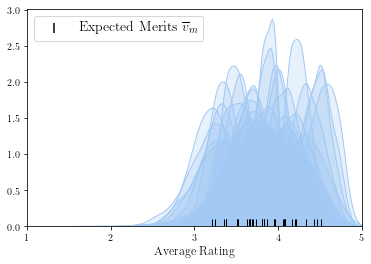

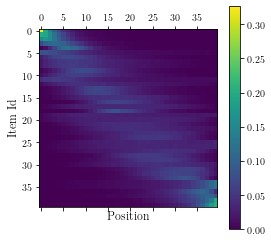

100%|██████████| 11/11 [06:34<00:00, 35.84s/it]

In [11]:
results = {}
NUM_RUNS = 1 
num_phis = 10
"""
Increase it to 20 to reproduce the results from the paper,
or load the pkl file below to visualize a past experiment run.
"""
for run in range(NUM_RUNS):
    for fraction in [0.1]:
        probability_of_r, movies, ratings_data = load_movielens_data(fraction, datadir='./ml-latest-small/')
        print("P(r) = ", probability_of_r)
        movie_ids_by_genre = get_movie_ids_by_genre_dict(movies, subsample_size=40)            
        for v_distr in ['log']:
            for scale in [1.0]:
                genre = "Comedy"
                print(
                    "Run {}-----Genre: {}----Subsample size: {}-----"
                    "Position Bias function: {} ----- s={}".format(
                        run, genre, fraction, v_distr, scale))
                result = run_experiment(genre, scale, v_distr, ratings_data, probability_of_r,
                                        util_transform=lambda x: x, 
                                        stacked=False, 
                                        num_alphas=num_phis, 
                                        subsample_size=None)
                results['_'.join([str(run), genre, str(fraction), v_distr, str(scale)])] = result
                print('=================================================')

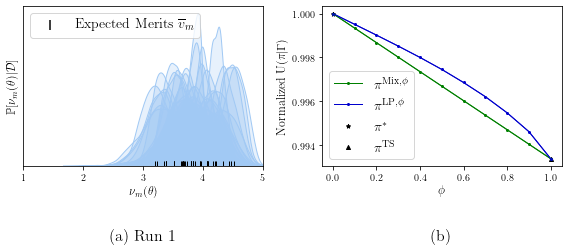

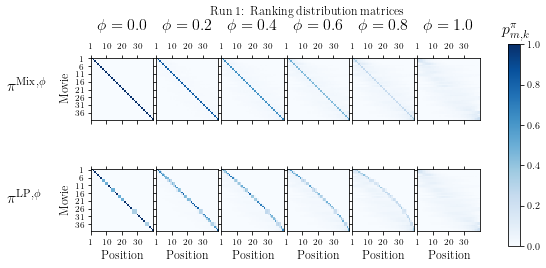

In [12]:
average_result = get_average_result(results)
plot_average_result(average_result, cmap='Blues')

### Loading a past experiment run


Since running 20 trials might take substantial amount of time, you may also load an included results file to visualize the results for an experiment with 20 independent trials. The Utility vs $\phi$ plot is averaged.

The pkl file can be downloaded from:
https://drive.google.com/file/d/1_19C2GyX83PgZc9gG1gvUBP-o9yb4fy7/view?usp=sharing

Number of Runs: 20
Plotting the matrix visualization for the first run.


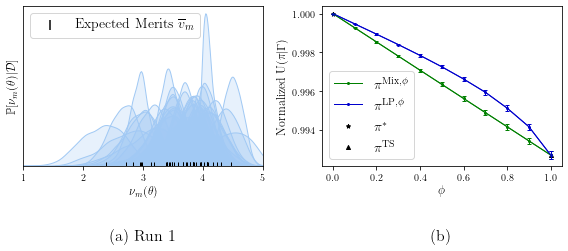

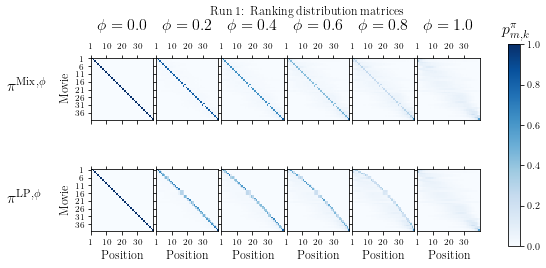

In [14]:
import pickle as pkl
results_dict = pkl.load(open('previous_run.pkl', 'rb'))
num_runs = len(results_dict.keys())
print("Number of Runs: {}".format(num_runs))
print("Plotting the matrix visualization for the first run.")
avg_results = get_average_result(results_dict)
plot_average_result(avg_results, cmap='Blues')